In [1]:
from os.path import join
import json
import csv
import glob
import os

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series, concat
from qiime2 import Artifact
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import t, sem
from IPython.display import Image
from numpy import array, log2, empty
from numpy.random import choice
from collections import defaultdict
from sklearn.feature_extraction.text import HashingVectorizer
from q2_feature_classifier._skl import _extract_reads
from joblib import Parallel, delayed

from paycheck.cross_validate import load_references
from itertools import product

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)
library(reshape2)
library(scales) # trans_new() is in the scales library
library(viridis)
library(philentropy)
library(ape)
library(grid)
library(gridExtra)

/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Want to understand how all the pieces fit together? See the R for Data
Science book: http://r4ds.had.co.nz/

  warnings.warn(x, RRuntimeWarning)
/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: viridisLite

  warnings.warn(x, RRuntimeWarning)
/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘viridis’


  warnings.warn(x, RRuntimeWarning)
/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following object is masked from ‘package:viridisLite’:

    viridis.map


  warnings.warn(x, RRuntimeWarning)
/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/rpy2/rinterface/__

```
def x_metric(x1, x2):
    return 1. - 2*x1.dot(x2.T)[0,0]/(x1.sum() + x2.sum())
def y_metric(lab1, lab2):
    for i in range(min(len(lab1), len(lab2))):
        if lab1[i] != lab2[i]:
            break
    semicolons = lab1[:i].count(';')
    if semicolons == 6 and lab1 == lab2:
        return 0
    return 7 - lab1[:i].count(';')
def calc_seq_map(X, y):
    seq_map = defaultdict(list)
    for x_, y_ in zip(X, y):
        seq_map[y_].append(x_)
    return seq_map
def ben_correlation(seq_map, sample_size=None, 
                    p=None, similarity_threshold=0.125):
    if sample_size is None:
        sample_size = len(y)
    taxonomic = empty(sample_size)
    feature = empty(sample_size)
    if p is None:
        y1 = choice(list(seq_map), size=sample_size)
        y2 = choice(list(seq_map), size=sample_size)
    else:
        y1 = choice(p.index, size=sample_size, p=p.values)
        y2 = choice(p.index, size=sample_size, p=p.values)
    for i, (y1_, y2_) in enumerate(zip(y1, y2)):
        x1_ = choice(seq_map[y1_], size=1)[0]
        x2_ = choice(seq_map[y2_], size=1)[0]
        taxonomic[i] = y_metric(y1_, y2_)
        feature[i] = x_metric(x1_, x2_)
    return (taxonomic*(feature < similarity_threshold)).mean()
```

In [4]:
def x_metric(x1, x2):
    return 1. - 2*x1.dot(x2.T)[0,0]/(x1.sum() + x2.sum())
def y_metric(lab1, lab2):
    for i in range(min(len(lab1), len(lab2))):
        if lab1[i] != lab2[i]:
            break
    semicolons = lab1[:i].count(';')
    if semicolons == 6 and lab1 == lab2:
        return 0
    return 7 - lab1[:i].count(';')
def calc_seq_map(X, y):
    seq_map = defaultdict(list)
    for x_, y_ in zip(X, y):
        seq_map[y_].append(x_)
    return seq_map
def ben_correlation(seq_map, sample_size=None, 
                    p=None, similarity_threshold=0.125):
    taxonomic = empty(sample_size)
    feature = empty(sample_size)
    if p is None:
        y1 = choice(list(seq_map), size=sample_size)
        y2 = choice(list(seq_map), size=sample_size)
    else:
        y1 = choice(p.index, size=sample_size, p=p.values)
        y2 = choice(p.index, size=sample_size, p=p.values)
    for i, (y1_, y2_) in enumerate(zip(y1, y2)):
        x1_ = choice(seq_map[y1_], size=1)[0]
        x2_ = choice(seq_map[y2_], size=1)[0]
        taxonomic[i] = y_metric(y1_, y2_)
        feature[i] = x_metric(x1_, x2_)
    return (taxonomic*(feature < similarity_threshold)).mean()

In [4]:
def x_metric(x1, x2):
    return 1. - 2*x1.dot(x2.T)[0,0]/(x1.sum() + x2.sum())

def y_metric(lab1, lab2):
    for i in range(min(len(lab1), len(lab2))):
        if lab1[i] != lab2[i]:
            break
    semicolons = lab1[:i].count(';')
    if semicolons == 6 and lab1 == lab2:
        return 0
    return 7 - lab1[:i].count(';')

def calc_seq_map(X, y):
    seq_map = defaultdict(list)
    for x_, y_ in zip(X, y):
        seq_map[y_].append(x_)
    return seq_map

def seq_probs(y, p, seq_map):
    return array([p[y_]/len(seq_map[y_]) for y_ in y])

def single_index(st, ix1, ix2, taxonomic, feature, y, p, average, seq_map, similarity_threshold):
    weight = empty(len(ix1))
    probs = seq_probs(y, weights.loc[st], seq_map)
    for i, (i1, i2) in enumerate(zip(ix1, ix2)):
        weight[i] = (probs[i1]/average[i1])*(probs[i2]/average[i2])
    return (taxonomic*weight*(feature < similarity_threshold)).mean()
    
def confusion_indices(X, y, weights, sample_size=None, 
                    similarity_threshold=0.25, n_jobs=4):
    seq_map = calc_seq_map(X, y)
    
    if sample_size is None:
        sample_size = len(y)
    average = seq_probs(y, weights.mean(axis=0), seq_map)
    ix1 = choice(range(len(y)), size=sample_size, p=average)
    ix2 = choice(range(len(y)), size=sample_size, p=average)
    taxonomic = empty(len(ix1))
    feature = empty(len(ix1))
    for i, (i1, i2) in enumerate(zip(ix1, ix2)):
        taxonomic[i] = y_metric(y[i1], y[i2])
        feature[i] = x_metric(X[i1], X[i2])
    
    results = Parallel(n_jobs=n_jobs, verbose=50, batch_size=1)(
        delayed(single_index)(
            st, ix1, ix2, taxonomic, feature, y, weights.loc[st], 
            average, seq_map, similarity_threshold)
        for st in weights.index)
    return dict(zip(weights.index, results))

In [5]:
empo3_dir = '/Users/benkaehler/Data/empo_3/'

In [6]:
columns = ['sample type', 'sample', 'fold']
data = {c:[] for c in columns}
for type_dir in glob.glob(join(empo3_dir, '*')):
    if not os.path.exists(join(type_dir, 'results', 'weights.qza')):
        continue
    type_ = os.path.basename(type_dir)
    if type_ in ('sterile-water-blank', 'single-strain', 'mock-community', 'nick', 'plant-surface'):
        continue
    for fold_dir in glob.glob(join(type_dir, 'tmp', 'fold-*')):
        _, fold = fold_dir.rsplit('-', 1)
        with open(join(fold_dir, 'sample_test.json')) as fh:
            try:
                samples = json.load(fh)
            except UnicodeDecodeError:
                print(join(fold_dir, 'sample_test.json'), 'is corrupted')
        data['sample'].extend(samples)
        data['sample type'].extend([type_]*len(samples))
        data['fold'].extend([fold]*len(samples))
folds = DataFrame(data)

In [7]:
abundances = read_csv(join(empo3_dir, 'abundances.tsv'), sep='\t')
abundances = abundances.set_index(['sample type', 'sample'])

In [8]:
prf = read_csv(join(empo3_dir, 'eval_taxa_prf.tsv'), sep='\t')

In [9]:
prf = prf.join(abundances, ['sample type', 'sample'])

In [10]:
folds = folds.set_index(['sample type', 'sample'])
prf = prf.join(folds, ['sample type', 'sample'])

In [11]:
prf = prf[prf['method'] == 'weighted']
level7 = prf[prf['level'] == 7]

In [12]:
grouped = level7.groupby(['sample type', 'class weights', 'fold'])
def weighted_stats(x):
    d1 = DescrStatsW(x['F-measure'], weights=x['abundance'])
    return Series([d1.mean], index=['mean'])
figure1 = grouped.apply(weighted_stats)
figure1.reset_index(inplace=True)

In [13]:
diff = []
for row in figure1.iterrows():
    diff.append(float(
        row[1]['mean'] - 
        figure1[(figure1['sample type'] == row[1]['sample type']) &
                (figure1['fold'] == row[1].fold) &
                (figure1['class weights'] == 'bespoke70')]['mean']))
figure1['diff'] = diff

In [14]:
grouped = figure1.groupby(['sample type', 'class weights'])
def weighted_stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    lower, upper = mu-se, mu+se
    diff = x['diff'].mean()
    se = sem(x['diff'])
    dlower, dupper = diff-se, diff+se
    return Series([mu, lower, upper, diff, dlower, dupper],
                  index=['mean', 'lower', 'upper', 'diff', 'diff lower', 'diff upper'])
figure1 = grouped.apply(weighted_stats)
figure1.reset_index(inplace=True)

In [15]:
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline',
    'average', 'uniform70', 'bespoke70']
new_labels = [
        'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)',
    'Average', 'Uniform', 'Bespoke']
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['class weights'] == old, 'class weights'] = new
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline'
]
new_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
for old, new in zip(old_labels, new_labels):
    figure1.loc[figure1['sample type'] == old, 'sample type'] = new

In [16]:
figure1

,sample type,class weights,mean,lower,upper,diff,diff lower,diff upper
0,Animal corpus,Animal distal gut,0.741338,0.722511,0.760165,-0.125610,-0.143053,-0.108166
1,Animal corpus,Animal proximal gut,0.771221,0.752292,0.790150,-0.095727,-0.106035,-0.085418
2,Animal corpus,Animal secretion,0.759966,0.738261,0.781670,-0.106982,-0.121172,-0.092793
3,Animal corpus,Animal surface,0.772857,0.755029,0.790685,-0.094091,-0.106117,-0.082065
4,Animal corpus,Average,0.833467,0.824172,0.842761,-0.033481,-0.037434,-0.029529
5,Animal corpus,Bespoke,0.866948,0.856458,0.877438,0.000000,0.000000,0.000000
6,Animal corpus,Plant corpus,0.783531,0.766196,0.800867,-0.083417,-0.091966,-0.074867
7,Animal corpus,Plant rhizosphere,0.648949,0.630334,0.667564,-0.217999,-0.229422,-0.206575
8,Animal corpus,Sediment (non-saline),0.679300,0.665598,0.693002,-0.187648,-0.194647,-0.180649
9,Animal corpus,Sediment (saline),0.722046,0.707905,0.736187,-0.144902,-0.149443,-0.140361


In [17]:
figure1.loc[figure1['class weights'] == 'Bespoke', 'class weights'] = \
    figure1.loc[figure1['class weights'] == 'Bespoke', 'sample type']

In [18]:
figure1['comparison'] = 'Uniform Is Better'

In [19]:
for st in set(figure1['sample type']):
    average = float(
        figure1[(figure1['class weights'] == 'Average') &
                (figure1['sample type'] == st)]['mean'])
    uniform = float(
        figure1[(figure1['class weights'] == 'Uniform') &
                (figure1['sample type'] == st)]['mean'])
    for i in range(len(figure1)):
        if figure1.iloc[i]['class weights'] == figure1.iloc[i]['sample type']:
            figure1['comparison'].iloc[i] = 'Bespoke'
        elif figure1.iloc[i]['sample type'] == st and \
            figure1.iloc[i]['mean'] > average:
            figure1['comparison'].iloc[i] = 'Better Than Average'
        elif figure1.iloc[i]['sample type'] == st and \
            figure1.iloc[i]['mean'] > uniform:
            figure1['comparison'].iloc[i] = 'Better Than Uniform'

/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
types = []
weightses = []
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline'
]
new_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
type_map = dict(zip(old_labels, new_labels))
for type_dir in glob.glob(join(empo3_dir, '*')):
    if not os.path.exists(join(type_dir, 'results', 'weights.qza')):
        continue
    type_ = os.path.basename(type_dir)
    if type_ in ('nick', 'sterile-water-blank', 'single-strain', 'mock-community', 'nick', 'plant-surface'):
        continue
    types.append(type_map[type_])
    weights = Artifact.load(join(type_dir, 'results', 'weights.qza'))
    weightses.append(weights.view(DataFrame))
weightrix = concat(weightses).T
weightrix['Average'] = weightrix.mean(axis=1)
weightrix['Uniform'] = 1./len(weightrix)
weightrix = weightrix.T
types += 'Average', 'Uniform'
weightrix.index = types

In [21]:
entropy = {}
for st, probs in zip(types, weightrix.values):
    entropy[st] = (-probs*log2(probs)).sum()

In [22]:
kl = defaultdict(dict)
for type1, type2 in product(types, types):
    p = weightrix.loc[type1]
    q = weightrix.loc[type2]
    kl[type1][type2] = -(p*log2(q/p)).sum()

```
ref_taxa, ref_seqs = load_references(
    join(empo3_dir, 'ref', '99_otu_taxonomy.txt'), join(empo3_dir, 'ref', '99_otus_v4.fasta'))
seq_ids, X = _extract_reads(ref_seqs)
data = [(ref_taxa[s], x) for s, x in zip(seq_ids, X) if s in ref_taxa]
y, X = list(zip(*data))
feat_ext = HashingVectorizer(
    **{'analyzer': 'char_wb',
       'n_features': 8192,
       'ngram_range': [7, 7],
       'alternate_sign': False})
X = feat_ext.transform(X)
X = [(x != 0).astype(int) for x in X]
seq_map = calc_seq_map(X, y)
index = {}
sample_types = [st for st in types if st not in ('Average', 'Uniform')]
results = Parallel(n_jobs=4, verbose=50, batch_size=1)(
    delayed(ben_correlation)(
        seq_map, 100000, weightrix.loc[st],
        similarity_threshold=0.25) 
    for st in sample_types)
index = dict(zip(sample_types, results))
```

In [103]:
ref_taxa, ref_seqs = load_references(
    join(empo3_dir, 'ref', '99_otu_taxonomy.txt'), join(empo3_dir, 'ref', '99_otus_v4.fasta'))
seq_ids, X = _extract_reads(ref_seqs)
data = [(ref_taxa[s], x) for s, x in zip(seq_ids, X) if s in ref_taxa]
y, X = list(zip(*data))
feat_ext = HashingVectorizer(
    **{'analyzer': 'char_wb',
       'n_features': 8192,
       'ngram_range': [7, 7],
       'alternate_sign': False})
X = feat_ext.transform(X)
X = [(x != 0).astype(int) for x in X]
weights = weightrix[(weightrix.index != 'Average') &
                    (weightrix.index != 'Uniform')]
index = confusion_indices(X, y, weights, sample_size=100000000)

[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  7.9min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  8.1min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  8.8min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  9.4min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 16.0min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed: 16.7min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed: 17.6min
[Parallel(n_jobs=4)]: Done   8 out of  14 | elapsed: 18.5min remaining: 13.9min
[Parallel(n_jobs=4)]: Done   9 out of  14 | elapsed: 24.4min remaining: 13.5min
[Parallel(n_jobs=4)]: Done  10 out of  14 | elapsed: 25.0min remaining: 10.0min
[Parallel(n_jobs=4)]: Done  11 out of  14 | elapsed: 25.6min remaining:  7.0min
[Parallel(n_jobs=4)]: Done  12 out of  14 | elapsed: 26.3min remaining:  4.4min
[Parallel(n_jobs=4)]: Done  14 out of  14 | elapsed: 31.5min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  14 out of  14 | elapsed: 31.5min finished


In [104]:
with open(join(empo3_dir, 'confusion_index.json'), 'w') as index_fp:
    json.dump(index, index_fp)

In [23]:
with open(join(empo3_dir, 'confusion_index.json')) as index_fp:
    index = json.load(index_fp)

In [24]:
index

{'Animal corpus': 0.006014443730596228,
 'Animal distal gut': 0.0025316180846757298,
 'Animal proximal gut': 0.04152757391779269,
 'Animal secretion': 0.0059512947997995,
 'Animal surface': 0.005552188909783495,
 'Plant corpus': 0.0005577874348046291,
 'Plant rhizosphere': 0.0024645744541194788,
 'Sediment (non-saline)': 0.00274021118894062,
 'Sediment (saline)': 0.000737250780933061,
 'Soil (non-saline)': 0.00365985039514027,
 'Surface (non-saline)': 0.00626067723512616,
 'Surface (saline)': 0.013294817570125876,
 'Water (non-saline)': 0.004774203222857036,
 'Water (saline)': 0.006099224142836564}

In [25]:
#figure1 = figure1[(figure1['class weights'] != 'Average') &
#                  (figure1['class weights'] != 'Uniform')]
figure1['dissimilarity'] = 0
figure1['entropy'] = 0
figure1['index'] = 0
for i in range(len(figure1)):
    sample_type = figure1['sample type'].iloc[i]
    class_weights = figure1['class weights'].iloc[i]
    figure1['dissimilarity'].iloc[i] = kl[sample_type][class_weights]
    figure1['entropy'].iloc[i] = entropy[sample_type]
    figure1['index'].iloc[i] = index[sample_type]

/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [26]:
figure1

,sample type,class weights,mean,lower,upper,diff,diff lower,diff upper,comparison,dissimilarity,entropy,index
0,Animal corpus,Animal distal gut,0.741338,0.722511,0.760165,-0.125610,-0.143053,-0.108166,Uniform Is Better,9.156867,7.245919,0.006014
1,Animal corpus,Animal proximal gut,0.771221,0.752292,0.790150,-0.095727,-0.106035,-0.085418,Better Than Uniform,7.817717,7.245919,0.006014
2,Animal corpus,Animal secretion,0.759966,0.738261,0.781670,-0.106982,-0.121172,-0.092793,Uniform Is Better,11.250523,7.245919,0.006014
3,Animal corpus,Animal surface,0.772857,0.755029,0.790685,-0.094091,-0.106117,-0.082065,Better Than Uniform,5.780095,7.245919,0.006014
4,Animal corpus,Average,0.833467,0.824172,0.842761,-0.033481,-0.037434,-0.029529,Better Than Uniform,2.130834,7.245919,0.006014
5,Animal corpus,Animal corpus,0.866948,0.856458,0.877438,0.000000,0.000000,0.000000,Bespoke,-0.000000,7.245919,0.006014
6,Animal corpus,Plant corpus,0.783531,0.766196,0.800867,-0.083417,-0.091966,-0.074867,Better Than Uniform,11.633403,7.245919,0.006014
7,Animal corpus,Plant rhizosphere,0.648949,0.630334,0.667564,-0.217999,-0.229422,-0.206575,Uniform Is Better,15.046224,7.245919,0.006014
8,Animal corpus,Sediment (non-saline),0.679300,0.665598,0.693002,-0.187648,-0.194647,-0.180649,Uniform Is Better,13.747984,7.245919,0.006014
9,Animal corpus,Sediment (saline),0.722046,0.707905,0.736187,-0.144902,-0.149443,-0.140361,Uniform Is Better,9.769637,7.245919,0.006014


In [28]:
no_bespoke = figure1[figure1['sample type'] != figure1['class weights']]

In [29]:
%%R -i figure1

figure1$weights.category = figure1$class.weights
figure1$weights.category[figure1$class.weights == figure1$sample.type] = 'Bespoke'
figure1$weights.category[figure1$weights.category != 'Bespoke' &
                         figure1$weights.category != 'Average' &
                         figure1$weights.category != 'Uniform'] = 'Other'

figure1 <- figure1[figure1$weights.category == 'Bespoke',]

fit <- lm(data=figure1, mean ~ entropy)
print(summary(fit))
print(anova(fit))

fit <- lm(data=figure1, mean ~ log(index))
print(summary(fit))
print(anova(fit))

ggplot(data=figure1, aes(x=log(index), y=mean)) +
    stat_smooth(method='lm', colour='black') +
    geom_point(aes(colour=sample.type, shape=sample.type)) +
    theme_bw() + labs(x='Confusion Index', y='Bespoke F-measure') +
    scale_color_viridis(name='EMPO 3 Habitat', discrete = TRUE, option='inferno') +
    scale_shape_manual(name='EMPO 3 Habitat', values=rep(15:18, 4)) +
    geom_errorbar(aes(ymin=lower, ymax=upper),
                  width=0.2,alpha=0.5)

ggsave(file="bc-figure2b.png", width=5, height=5, dpi=300)


Call:
lm(formula = mean ~ entropy, data = figure1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.060196 -0.016088  0.007335  0.020167  0.036896 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.927958   0.041451  22.387 3.73e-11 ***
entropy     -0.006178   0.006154  -1.004    0.335    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.028 on 12 degrees of freedom
Multiple R-squared:  0.07748,	Adjusted R-squared:  0.0006025 
F-statistic: 1.008 on 1 and 12 DF,  p-value: 0.3352

Analysis of Variance Table

Response: mean
          Df    Sum Sq    Mean Sq F value Pr(>F)
entropy    1 0.0007903 0.00079028  1.0078 0.3352
Residuals 12 0.0094096 0.00078413               

Call:
lm(formula = mean ~ log(index), data = figure1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.032252 -0.011182  0.000868  0.011954  0.026486 

Coefficients:
             Estimate Std. Error t value Pr(

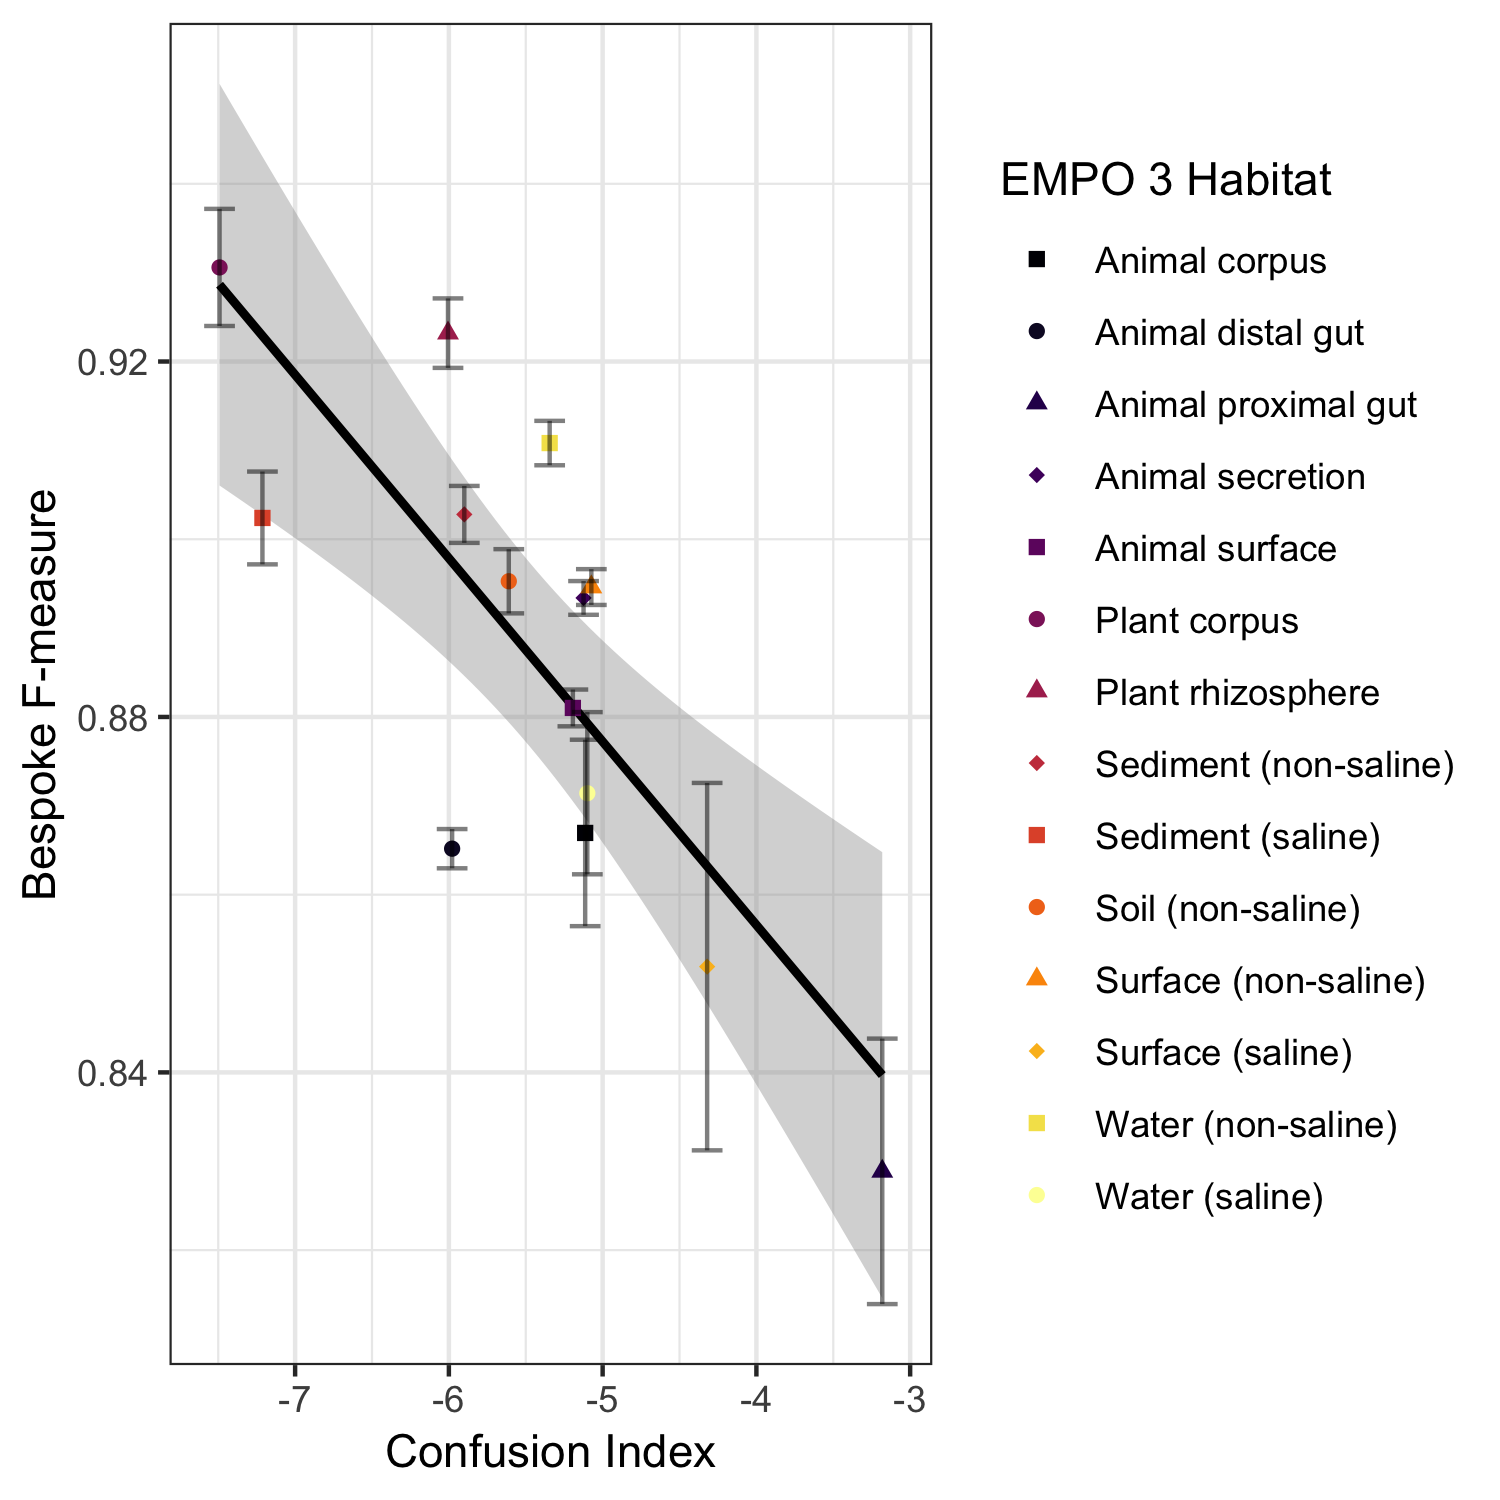

In [30]:
Image("bc-figure2b.png")

In [31]:
%%R -i figure1
fit <- lm(data=figure1, mean ~ dissimilarity)

print(summary(fit))
print(anova(fit))
print(cor.test(figure1$dissimilarity, figure1$mean))

figure1$weights.category = figure1$class.weights
figure1$weights.category[figure1$class.weights == figure1$sample.type] = 'Bespoke'
figure1$weights.category[figure1$weights.category != 'Bespoke' &
                         figure1$weights.category != 'Average' &
                         figure1$weights.category != 'Uniform'] = 'Other'

ggplot(data=figure1, aes(x=dissimilarity, y=scaled)) +
       geom_point(aes(colour=weights.category)) + stat_smooth(method='lm')

/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in FUN(X[[i]], ...) : object 'scaled' not found

  warnings.warn(x, RRuntimeWarning)


RRuntimeError: Error in FUN(X[[i]], ...) : object 'scaled' not found



Call:
lm(formula = mean ~ entropy, data = figure1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.060196 -0.016088  0.007335  0.020167  0.036896 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.927958   0.041451  22.387 3.73e-11 ***
entropy     -0.006178   0.006154  -1.004    0.335    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.028 on 12 degrees of freedom
Multiple R-squared:  0.07748,	Adjusted R-squared:  0.0006025 
F-statistic: 1.008 on 1 and 12 DF,  p-value: 0.3352

Analysis of Variance Table

Response: mean
          Df    Sum Sq    Mean Sq F value Pr(>F)
entropy    1 0.0007903 0.00079028  1.0078 0.3352
Residuals 12 0.0094096 0.00078413               

Call:
lm(formula = mean ~ log(index), data = figure1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.032252 -0.011182  0.000868  0.011954  0.026486 

Coefficients:
             Estimate Std. Error t value Pr(

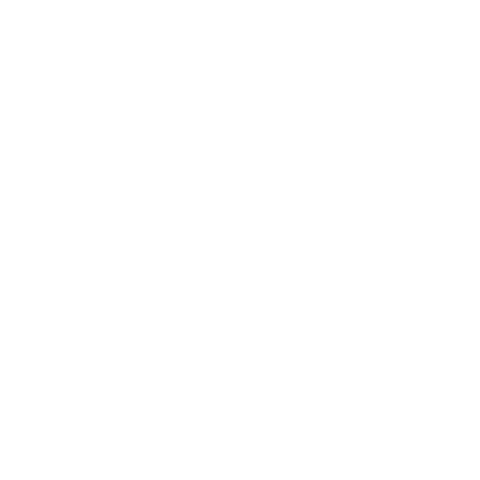

In [32]:
%%R -i no_bespoke,figure1

figure1$weights.category = figure1$class.weights
figure1$weights.category[figure1$class.weights == figure1$sample.type] = 'Bespoke'
figure1$weights.category[figure1$weights.category != 'Bespoke' &
                         figure1$weights.category != 'Average' &
                         figure1$weights.category != 'Uniform'] = 'Other'

figure1 <- figure1[figure1$weights.category == 'Bespoke',]

fit <- lm(data=figure1, mean ~ entropy)
print(summary(fit))
print(anova(fit))

fit <- lm(data=figure1, mean ~ log(index))
print(summary(fit))
print(anova(fit))

p1 <- ggplot(data=figure1, aes(x=log(index), y=mean)) +
    stat_smooth(method='lm', colour='black') +
    geom_point(aes(colour=sample.type, shape=sample.type)) +
    theme_bw() + labs(x='Confusion Index', y='Bespoke F-measure') +
    scale_color_viridis(name='EMPO 3 Habitat', discrete = TRUE, option='inferno') +
    scale_shape_manual(name='EMPO 3 Habitat', values=rep(15:18, 4)) +
    geom_errorbar(aes(ymin=lower, ymax=upper),
                  width=0.05,alpha=0.5) +
    theme(legend.position="none")


no_bespoke$weights.category = no_bespoke$class.weights
no_bespoke$weights.category[no_bespoke$class.weights == no_bespoke$sample.type] = 'Bespoke'
no_bespoke$weights.category[no_bespoke$weights.category != 'Bespoke' &
                         no_bespoke$weights.category != 'Average' &
                         no_bespoke$weights.category != 'Uniform'] = 'Other'

no_bespoke <- no_bespoke[no_bespoke$weights.category == 'Other',]

fit <- lm(data=no_bespoke, diff ~ dissimilarity)
print(summary(fit))
print(anova(fit))
print(cor.test(no_bespoke$dissimilarity, no_bespoke$diff))

p2 <- ggplot(data=no_bespoke, aes(x=dissimilarity, y=diff)) +
    geom_smooth(method=lm, colour='black') +
    geom_point(aes(colour=sample.type, shape=sample.type)) +
    theme_bw() + labs(x='Kullback-Leibler Divergence to Bespoke Weights',
                      y='Difference of F-measure and Bespoke F-measure') +
    scale_color_viridis(name='EMPO 3 Habitat', discrete = TRUE, option='inferno') +
    scale_shape_manual(name='EMPO 3 Habitat', values=rep(15:18, 4)) +
    geom_errorbar(aes(ymin=diff.lower, ymax=diff.upper),
                  width=0.2,alpha=0.5) +
    theme(legend.position="bottom")

g <- ggplotGrob(p2)$grobs
legend <- g[[which(sapply(g, function(x) x$name) == "guide-box")]]
lheight <- sum(legend$height)         
p2 <- p2 + theme(legend.position="none")
                          
p2 <- arrangeGrob(p2, top = textGrob("a", x = unit(0, "npc")
         , y   = unit(1, "npc"), just=c("left","top"),
         gp=gpar(col="black", fontsize=18)))
p1 <- arrangeGrob(p1, top = textGrob("b", x = unit(0, "npc")
         , y   = unit(1, "npc"), just=c("left","top"),
         gp=gpar(col="black", fontsize=18)))
                          
g <- arrangeGrob(p2, p1, legend, ncol=2,
             heights = unit.c(unit(1, "npc") - lheight, lheight),
             widths = c(1, 1),
             layout_matrix = rbind(c(1, 2), c(3, 3)))

ggsave(file="bc-figure2.png", g, width=10, height=5, dpi=300)

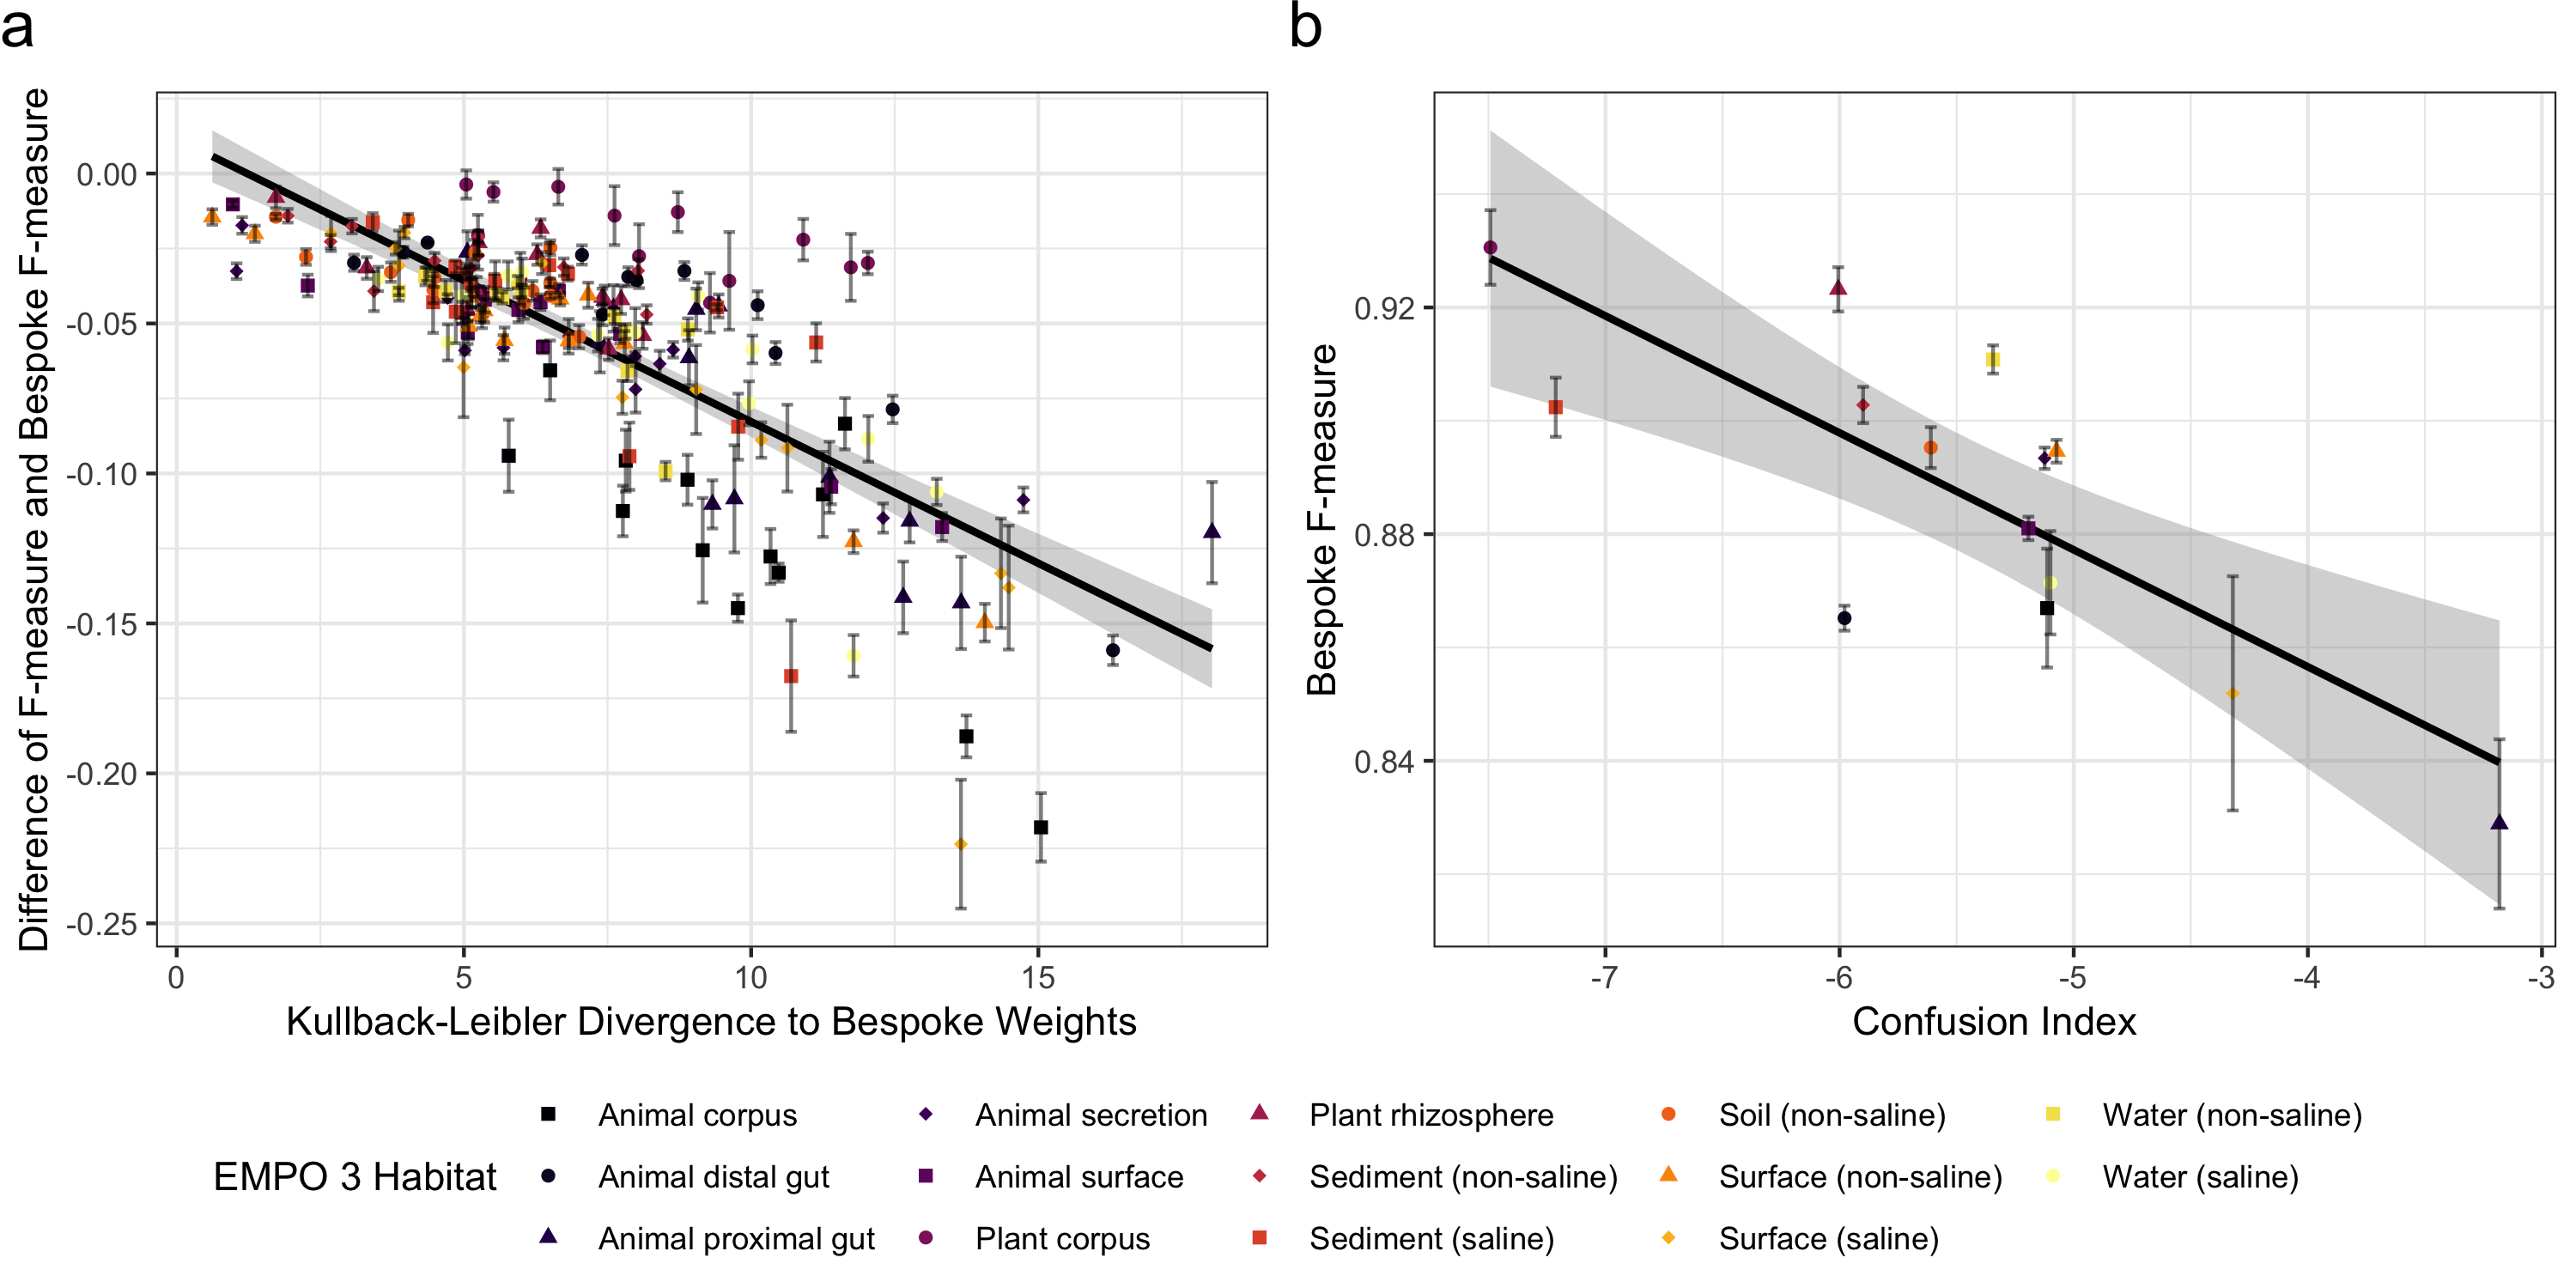

In [33]:
Image("bc-figure2.png")

In [41]:
len(no_bespoke)

210

In [ ]:
%%R -i no_bespoke

no_bespoke$weights.category = no_bespoke$class.weights
no_bespoke$weights.category[no_bespoke$class.weights == no_bespoke$sample.type] = 'Bespoke'
no_bespoke$weights.category[no_bespoke$weights.category != 'Bespoke' &
                         no_bespoke$weights.category != 'Average' &
                         no_bespoke$weights.category != 'Uniform'] = 'Other'

no_bespoke <- no_bespoke[no_bespoke$weights.category == 'Other',]

fit <- lm(data=no_bespoke, diff ~ dissimilarity)
print(summary(fit))
print(anova(fit))
print(cor.test(no_bespoke$dissimilarity, no_bespoke$diff))



ggplot(data=no_bespoke, aes(x=dissimilarity, y=diff)) +
    geom_smooth(method=lm, colour='black') +
    geom_point(aes(colour=sample.type, shape=sample.type)) +
    theme_bw() + labs(x='Kullback-Leibler Divergence', y='F-measure Difference to Bespoke') +
    scale_color_viridis(name='EMPO 3 Habitat', discrete = TRUE, option='inferno') +
    scale_shape_manual(name='EMPO 3 Habitat', values=rep(15:18, 4)) +
    geom_errorbar(aes(ymin=diff.lower, ymax=diff.upper),
                  width=0.2,alpha=0.5)

grid_arrange_shared_legend <- function(...) {
    plots <- list(...)
    g <- ggplotGrob(plots[[1]] + theme(legend.position="bottom"))$grobs
    legend <- g[[which(sapply(g, function(x) x$name) == "guide-box")]]
    lheight <- sum(legend$height)
    grid.arrange(
        do.call(arrangeGrob, lapply(plots, function(x)
            x + theme(legend.position="none"))),
        legend,
        ncol = 1,
        heights = unit.c(unit(1, "npc") - lheight, lheight))
}

In [68]:
%%R -i figure1
fit <- lm(data=figure1, mean ~ dissimilarity)
cbind(figure1, residuals(fit))
ggplot(data=figure1, aes(x=log(index), y=residuals(fit))) +
    geom_point(aes(colour=class.weights)) + stat_smooth(method = "lm")

/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in FUN(X[[i]], ...) : object 'index' not found

  warnings.warn(x, RRuntimeWarning)


RRuntimeError: Error in FUN(X[[i]], ...) : object 'index' not found


In [264]:
%%R -i figure1
fit <- lm(mean ~ dissimilarity + sample.type, data=figure1)
print(summary(fit))
print(anova(fit))


Call:
lm(formula = mean ~ dissimilarity + sample.type, data = figure1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.109641 -0.007830  0.002334  0.011514  0.051584 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       0.8290698  0.0068558 120.930  < 2e-16 ***
dissimilarity                    -0.0083486  0.0004517 -18.483  < 2e-16 ***
sample.typeAnimal distal gut      0.0512434  0.0080699   6.350 1.32e-09 ***
sample.typeAnimal proximal gut   -0.0031727  0.0080501  -0.394   0.6939    
sample.typeAnimal secretion       0.0548278  0.0081250   6.748 1.45e-10 ***
sample.typeAnimal surface         0.0463176  0.0081556   5.679 4.49e-08 ***
sample.typePlant corpus           0.1436784  0.0080599  17.826  < 2e-16 ***
sample.typePlant rhizosphere      0.1059665  0.0081735  12.965  < 2e-16 ***
sample.typeSediment (non-saline)  0.0841333  0.0082404  10.210  < 2e-16 ***
sample.typeSediment (saline)      0.076

In [265]:
%%R -i figure1
fit <- lm(mean ~ dissimilarity + log(index), data=figure1)
print(summary(fit))
print(anova(fit))


Call:
lm(formula = mean ~ dissimilarity + log(index), data = figure1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.111713 -0.012766  0.004414  0.020531  0.057720 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.7287085  0.0124891   58.35   <2e-16 ***
dissimilarity -0.0093307  0.0005854  -15.94   <2e-16 ***
log(index)    -0.0302667  0.0020570  -14.71   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03144 on 221 degrees of freedom
Multiple R-squared:  0.7085,	Adjusted R-squared:  0.7058 
F-statistic: 268.5 on 2 and 221 DF,  p-value: < 2.2e-16

Analysis of Variance Table

Response: mean
               Df  Sum Sq Mean Sq F value    Pr(>F)    
dissimilarity   1 0.31681 0.31681  320.60 < 2.2e-16 ***
log(index)      1 0.21393 0.21393  216.49 < 2.2e-16 ***
Residuals     221 0.21838 0.00099                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ 

In [74]:
%%R -i figure1

figure1 <- figure1[figure1$class.weights == figure1$sample.type,]
fit1 <- lm(mean ~ log(index), data=figure1)
print(summary(fit1))

levels = c(
    'Animal distal gut',
    'Animal proximal gut',
    'Animal corpus',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
)
figure1$sample.type = factor(figure1$sample.type, levels=levels)
ggplot(data=figure1, aes(x=log(index), y=mean)) +
    geom_point(aes(colour=sample.type, shape=sample.type)) +
    stat_smooth(method="lm", colour="black") +
  theme_bw() +
  scale_colour_viridis(discrete = TRUE) +
    scale_shape_manual(name='EMPO 3 Habitat', values=rep(15:18, 4)) +
  labs(x='Log Confusion Index', y='F-measure') +
  guides(colour=guide_legend(title="EMPO 3 Habitat"))
ggsave(file="confusion-index.png", width=5, height=5, dpi=300)


Call:
lm(formula = mean ~ log(index), data = figure1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.032252 -0.011182  0.000868  0.011954  0.026486 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.774039   0.025491  30.366 1.02e-12 ***
log(index)  -0.020638   0.004574  -4.511 0.000712 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01776 on 12 degrees of freedom
Multiple R-squared:  0.6291,	Adjusted R-squared:  0.5982 
F-statistic: 20.35 on 1 and 12 DF,  p-value: 0.0007123



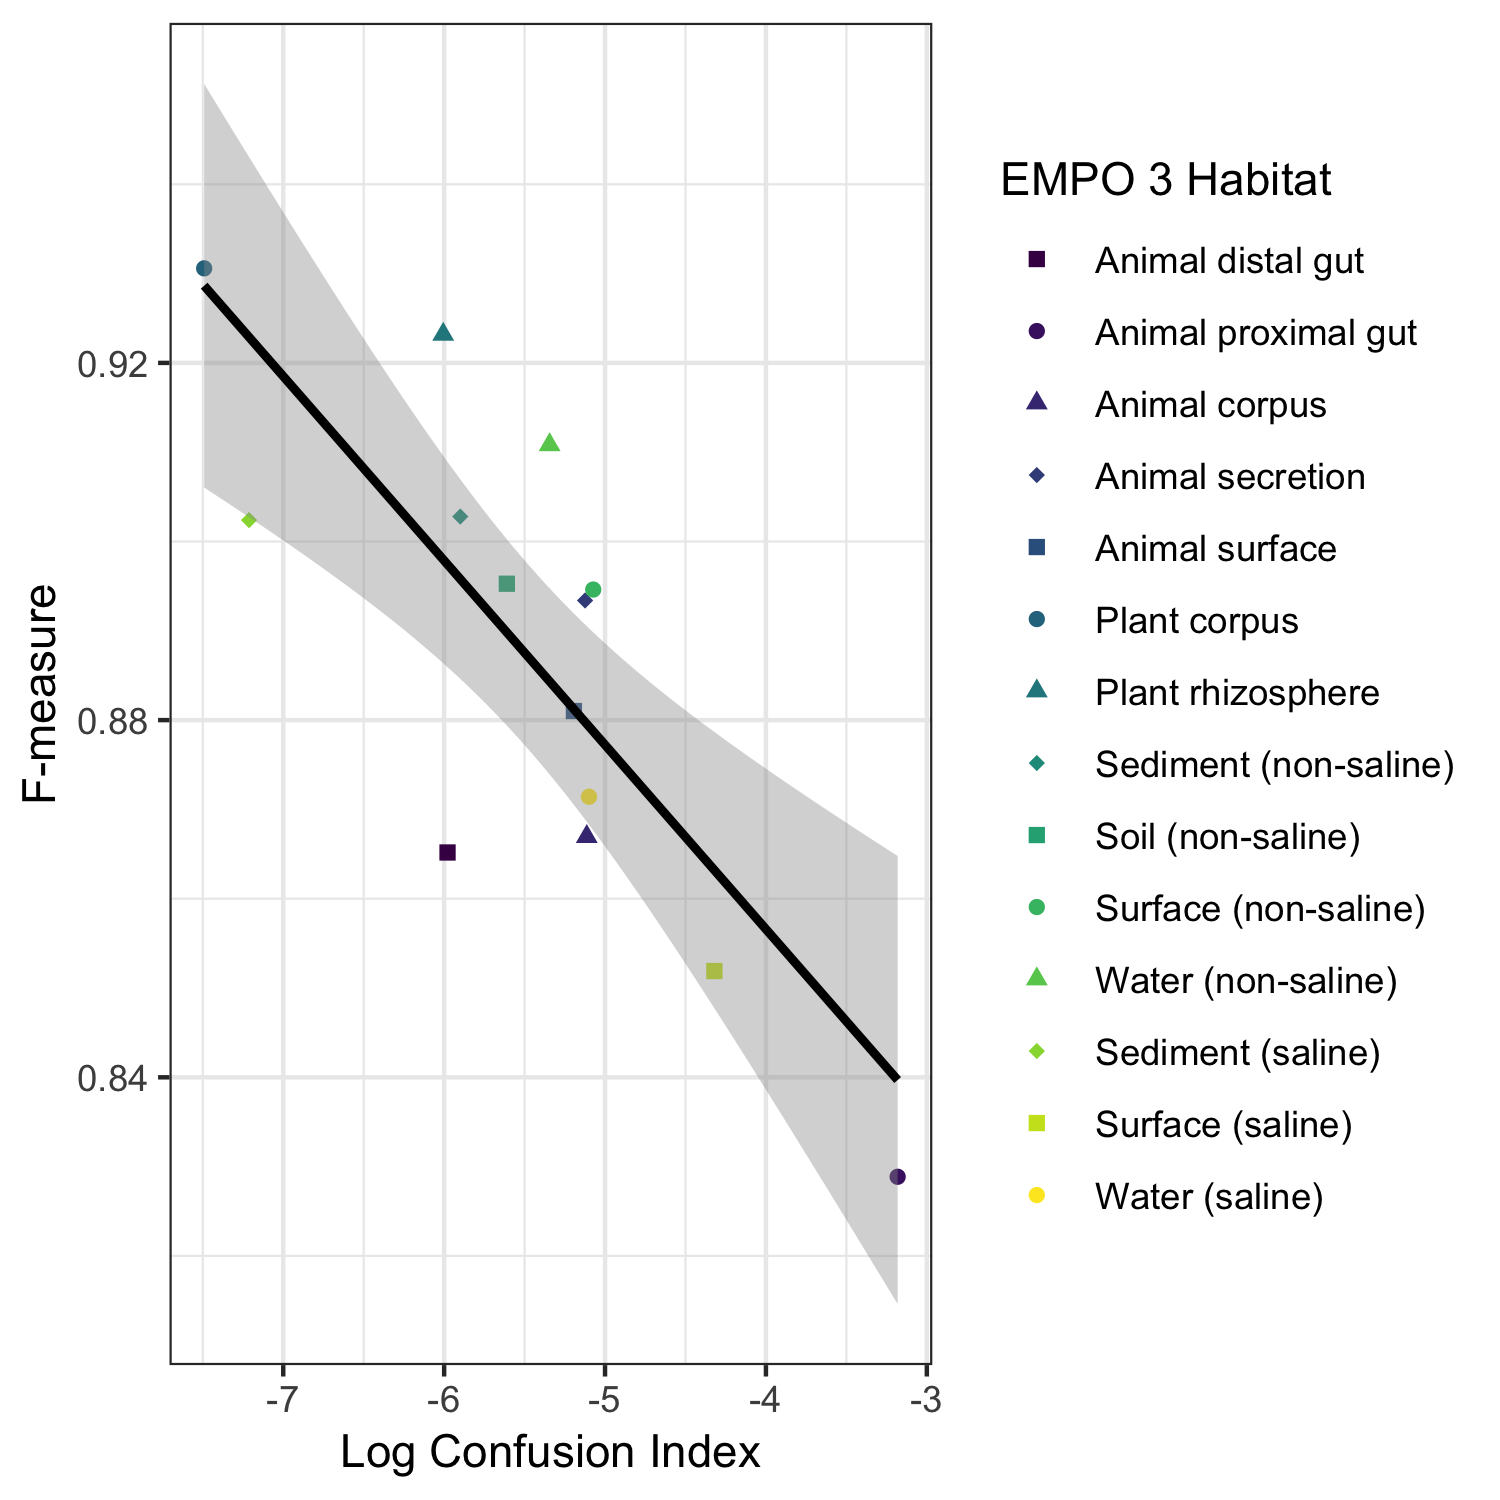

In [75]:
Image('confusion-index.png')

In [332]:
%%R -i figure1
fit1 <- lm(mean ~ log(index), data=figure1)
print(summary(fit1))

fit <- lm(mean ~ log(index) + dissimilarity, data=figure1)
print(summary(fit))
print(anova(fit))

figure1$weights.category = figure1$class.weights
figure1$weights.category[figure1$class.weights == figure1$sample.type] = 'Bespoke'
figure1$weights.category[figure1$weights.category != 'Bespoke' &
                         figure1$weights.category != 'Average' &
                         figure1$weights.category != 'Uniform'] = 'Other'

cbPalette <- c("#999999", "#56B4E9", "#E69F00", "#009E73", "#F0E442", "#0072B2", "#D55E00")
figure1$residuals = residuals(fit1)
figure1$weights.category = factor(figure1$weights.category, levels=c(
    'Other', 'Average', 'Uniform', 'Bespoke'
))
ggplot(data=figure1, aes(x=dissimilarity, y=residuals)) +
    geom_point(aes(colour=weights.category)) +
    stat_smooth(method="lm", colour="black") +
  theme_bw() +
  labs(x='Kullback-Leibler Divergence', y='Confusion Index Adjusted F-measure') +
  scale_colour_manual(values=cbPalette) +
  guides(colour=guide_legend(title="Taxonomic Weights", reverse=T))
ggsave(file="kld.png", width=5, height=5, dpi=300)


Call:
lm(formula = mean ~ log(index), data = figure1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.17412 -0.02463  0.01246  0.03090  0.08061 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.646873   0.016654   38.84   <2e-16 ***
log(index)  -0.034339   0.002986  -11.50   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04598 on 222 degrees of freedom
Multiple R-squared:  0.3734,	Adjusted R-squared:  0.3705 
F-statistic: 132.3 on 1 and 222 DF,  p-value: < 2.2e-16


Call:
lm(formula = mean ~ log(index) + dissimilarity, data = figure1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.111713 -0.012766  0.004414  0.020531  0.057720 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.7287085  0.0124891   58.35   <2e-16 ***
log(index)    -0.0302667  0.0020570  -14.71   <2e-16 ***
dissimilarity -0.0093307  0.0005854  -15.94   <2e-1

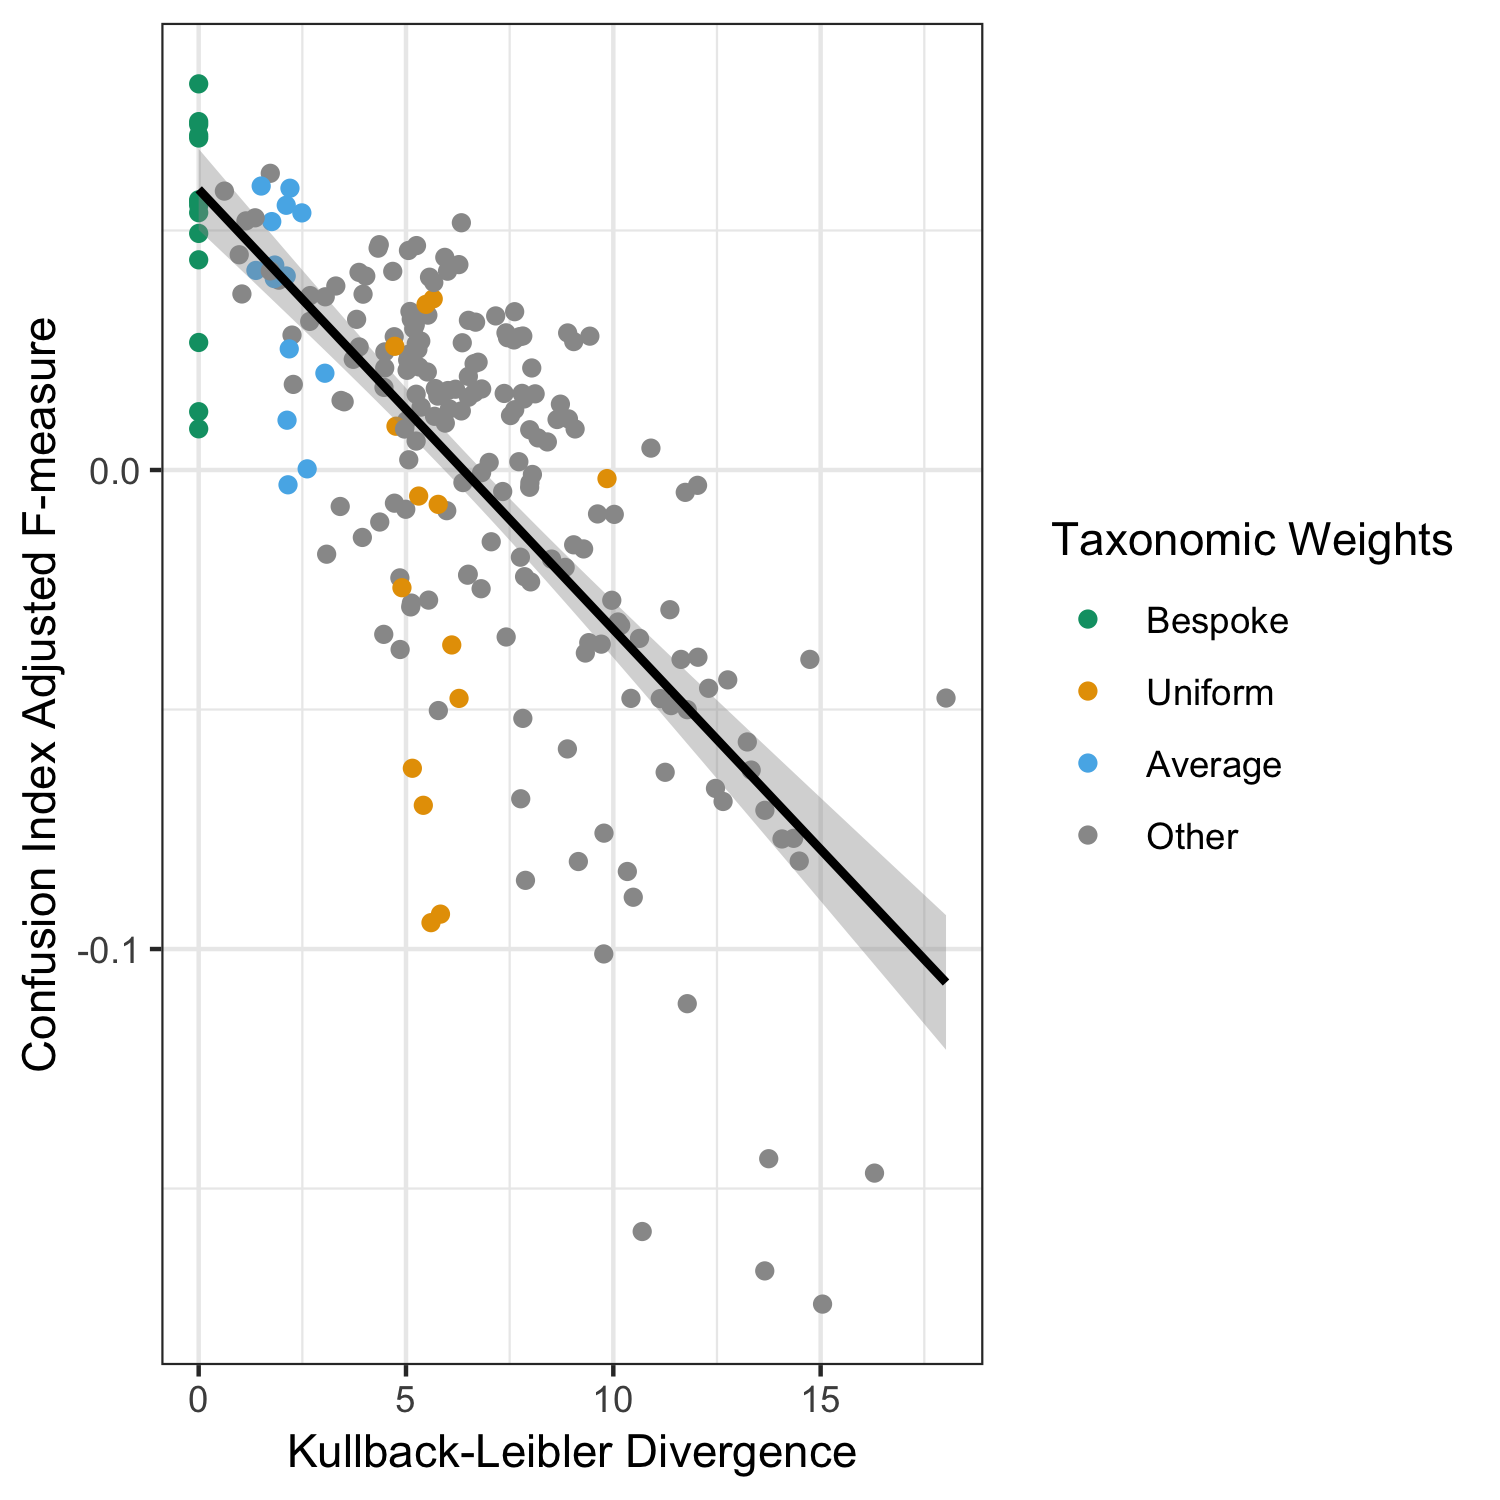

In [333]:
Image("kld.png")


Call:
lm(formula = mean ~ sample.type, data = figure1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.155501 -0.009958  0.003495  0.016547  0.108562 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       0.758386   0.009214  82.312  < 2e-16 ***
sample.typeAnimal distal gut      0.062495   0.013030   4.796 3.06e-06 ***
sample.typeAnimal proximal gut   -0.007368   0.013030  -0.565   0.5724    
sample.typeAnimal secretion       0.075592   0.013030   5.801 2.40e-08 ***
sample.typeAnimal surface         0.070848   0.013030   5.437 1.50e-07 ***
sample.typePlant corpus           0.152120   0.013030  11.675  < 2e-16 ***
sample.typePlant rhizosphere      0.132448   0.013030  10.165  < 2e-16 ***
sample.typeSediment (non-saline)  0.116944   0.013030   8.975  < 2e-16 ***
sample.typeSediment (saline)      0.096182   0.013030   7.382 3.60e-12 ***
sample.typeSoil (non-saline)      0.106117   0.013030   8.144 3.3

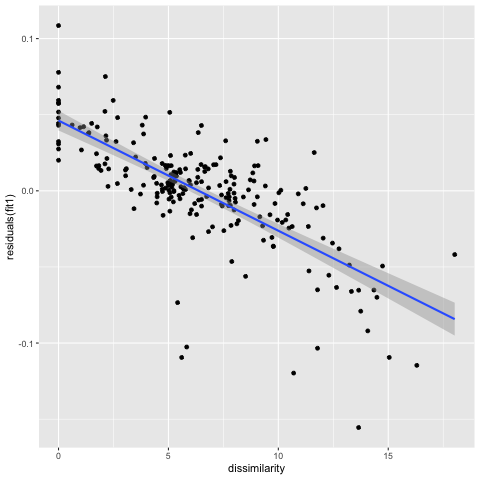

In [268]:
%%R -i figure1
fit1 <- lm(mean ~ sample.type, data=figure1)
print(summary(fit1))

fit <- lm(mean ~ dissimilarity + sample.type, data=figure1)
print(summary(fit))
print(anova(fit))

cbind(figure1, residuals(fit1))
ggplot(data=figure1, aes(x=dissimilarity, y=residuals(fit1))) +
    geom_point() + stat_smooth(method = "lm")

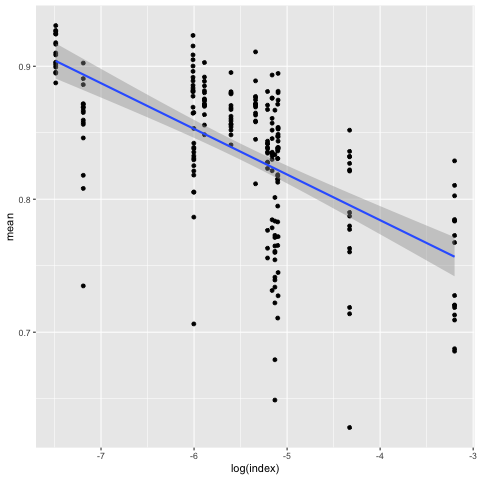

In [269]:
%%R -i figure1
ggplot(data=figure1, aes(x=log(index), y=mean)) +
    geom_point() + stat_smooth(method = "lm")

In [151]:
%%R -i figure1
levels = c(
    'Animal distal gut',
    'Animal proximal gut',
    'Animal corpus',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
)
figure1$sample.type = factor(figure1$sample.type, levels=levels)
fit1 <- lm(mean ~ sample.type, data=figure1)
print(summary(fit1))

fit <- lm(mean ~ sample.type + dissimilarity, data=figure1)
print(summary(fit))
print(anova(fit))

cld(fit)
#a1 <- aov(mean ~ sample.type, data=figure1)
#posthoc <- TukeyHSD(x=a1, 'sample.type', conf.level=0.95)
#print(posthoc)

cbind(figure1, residuals(fit1))
ggplot(data=figure1, aes(x=dissimilarity, y=residuals(fit1))) +
    geom_point() + stat_smooth(method = "lm")


Call:
lm(formula = mean ~ sample.type, data = figure1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.151326 -0.010245  0.003896  0.016379  0.114098 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       0.819679   0.009538  85.934  < 2e-16 ***
sample.typeAnimal proximal gut   -0.070706   0.013489  -5.242 4.38e-07 ***
sample.typeAnimal corpus         -0.066830   0.013489  -4.954 1.65e-06 ***
sample.typeAnimal secretion       0.018629   0.013489   1.381  0.16897    
sample.typeAnimal surface         0.012070   0.013489   0.895  0.37208    
sample.typePlant corpus           0.090446   0.013489   6.705 2.45e-10 ***
sample.typePlant rhizosphere      0.070018   0.013489   5.191 5.57e-07 ***
sample.typeSediment (non-saline)  0.054500   0.013489   4.040 7.87e-05 ***
sample.typeSoil (non-saline)      0.044920   0.013489   3.330  0.00105 ** 
sample.typeSurface (non-saline)   0.021845   0.013489   1.619  0.

/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error in cld(fit) : could not find function "cld"

  warnings.warn(x, RRuntimeWarning)


In [42]:
%%R -i figure1
figure1 <- figure1[figure1$class.weights != 'Uniform' &
                   figure1$class.weights != 'Average',]

print(sum(figure1$comparison == 'Better Than Average'))
print(sum(figure1$comparison == 'Better Than Uniform'))
print(sum(figure1$comparison == 'Uniform Is Better'))

levels = c(
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
)
figure1$sample.type = factor(figure1$sample.type, levels=rev(levels))
figure1$class.weights = factor(figure1$class.weights, levels=levels)
figure1$comparison[figure1$comparison == "Bespoke"] = "Bespoke Always Wins"
figure1$comparison = factor(figure1$comparison, levels=c(
    'Uniform Is Better',
    'Better Than Uniform',
    'Better Than Average',
    'Bespoke Always Wins'))
p <- ggplot(data=figure1, aes(class.weights, sample.type, fill=comparison)) +
    geom_tile(color = "white") +
    geom_text(size=2, color="#bbbbbb", aes(label=round(digits=0, 100*mean))) +
  scale_fill_viridis(discrete = TRUE, option='inferno') + # Change gradient color
  theme_minimal()+ # minimal theme
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
                                  size = 6, hjust = 1),
       axis.text.y = element_text(size=6)) +
 labs(y='EMPO3 Habitat', x='Taxonomic Weights') +
 guides(fill=guide_legend(title="Performance Comparison", reverse=T)) +
 coord_fixed()

ggsave(file="confusion.png", width=5, height=3, dpi=300)

[1] 8
[1] 109
[1] 65


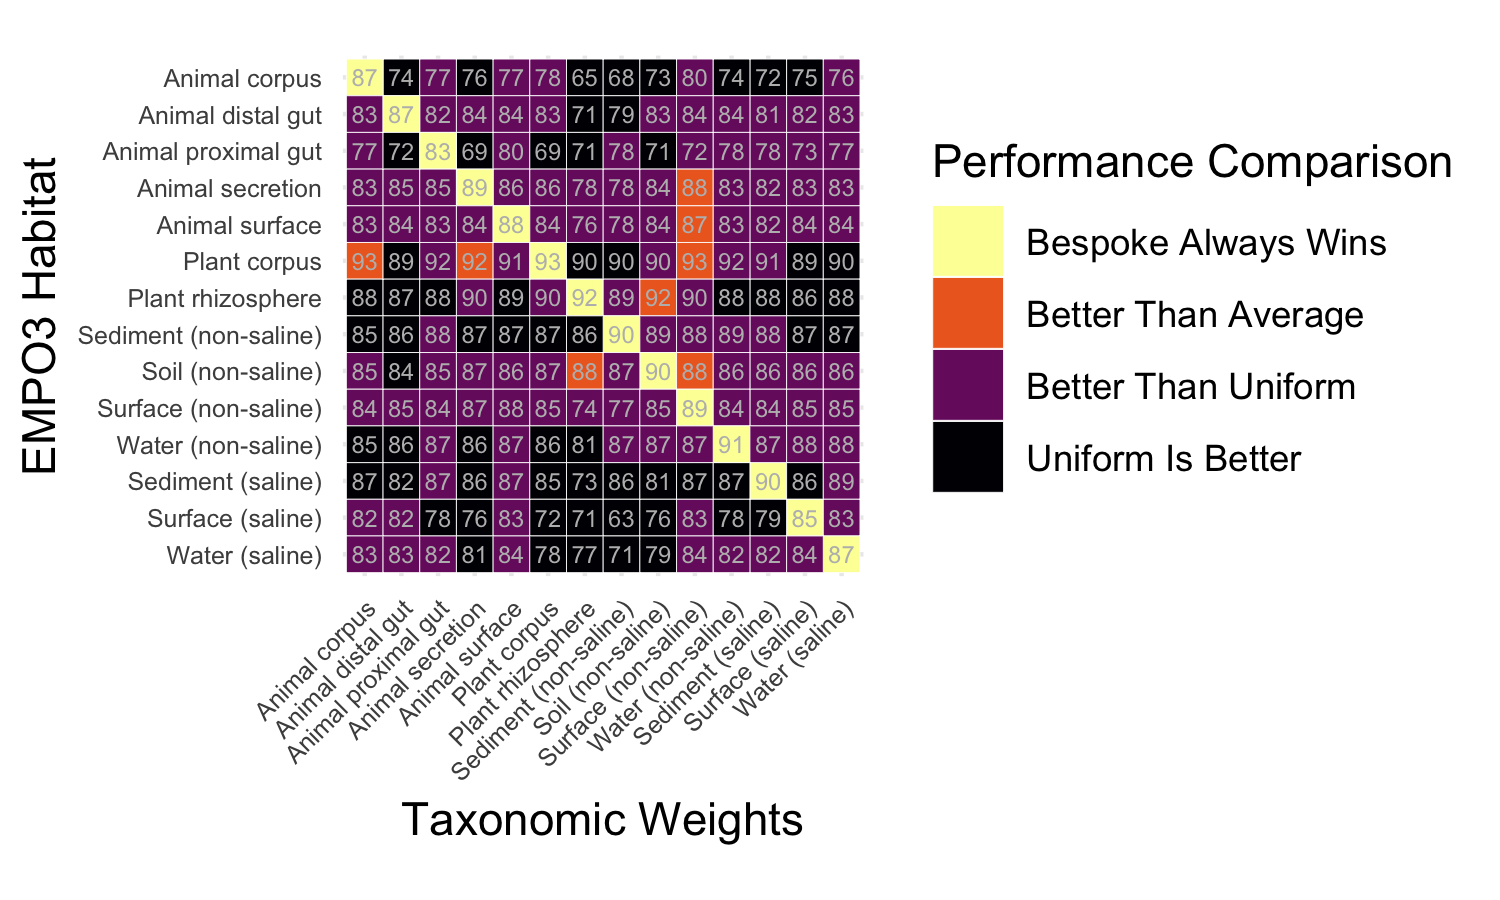

In [28]:
Image("confusion.png")

In [35]:
figure1

,sample type,class weights,mean,lower,upper,diff,diff lower,diff upper,comparison,dissimilarity,entropy,index
0,Animal corpus,Animal distal gut,0.741338,0.722511,0.760165,-0.125610,-0.143053,-0.108166,Uniform Is Better,9.156867,7.245919,0.006014
1,Animal corpus,Animal proximal gut,0.771221,0.752292,0.790150,-0.095727,-0.106035,-0.085418,Better Than Uniform,7.817717,7.245919,0.006014
2,Animal corpus,Animal secretion,0.759966,0.738261,0.781670,-0.106982,-0.121172,-0.092793,Uniform Is Better,11.250523,7.245919,0.006014
3,Animal corpus,Animal surface,0.772857,0.755029,0.790685,-0.094091,-0.106117,-0.082065,Better Than Uniform,5.780095,7.245919,0.006014
4,Animal corpus,Average,0.833467,0.824172,0.842761,-0.033481,-0.037434,-0.029529,Better Than Uniform,2.130834,7.245919,0.006014
5,Animal corpus,Animal corpus,0.866948,0.856458,0.877438,0.000000,0.000000,0.000000,Bespoke,-0.000000,7.245919,0.006014
6,Animal corpus,Plant corpus,0.783531,0.766196,0.800867,-0.083417,-0.091966,-0.074867,Better Than Uniform,11.633403,7.245919,0.006014
7,Animal corpus,Plant rhizosphere,0.648949,0.630334,0.667564,-0.217999,-0.229422,-0.206575,Uniform Is Better,15.046224,7.245919,0.006014
8,Animal corpus,Sediment (non-saline),0.679300,0.665598,0.693002,-0.187648,-0.194647,-0.180649,Uniform Is Better,13.747984,7.245919,0.006014
9,Animal corpus,Sediment (saline),0.722046,0.707905,0.736187,-0.144902,-0.149443,-0.140361,Uniform Is Better,9.769637,7.245919,0.006014


In [17]:
figure1['diff'] = 0
for i in range(len(figure1)):
    sample_type = figure1.iloc[i]['sample type']
    bespoke = float(figure1[(figure1['class weights'] == sample_type) &
                           (figure1['sample type'] == sample_type)]['mean'])
    figure1['diff'].iloc[i] = bespoke - figure1['mean'].iloc[i]
no_zeros = figure1[figure1["diff"] != 0]

/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
average = figure1[figure1['class weights'] == 'Average']
uniform = figure1[figure1['class weights'] == 'Uniform']
figure1 = figure1[(figure1['class weights'] != 'Uniform') &
                  (figure1['class weights'] != 'Average')]

In [16]:
max(figure1['upper'] - figure1['lower'])

0.13128721225598428

In [17]:
bespoke = figure1[figure1['class weights'] == 'Bespoke']['mean']
print(min(bespoke), max(bespoke))
uniform = figure1[figure1['class weights'] == 'Uniform']['mean']
print(min(uniform), max(uniform))

0.8288638081095409 0.9305880832502146
0.720229783917639 0.9021711163046009


In [18]:
len(set(level7['sample']))

21513

In [19]:
list(set(level7['sample']))[:10]

['11113.907.36782',
 '2192.H01a.Bedroom.Floor.268.lane2.NoIndex.L002.30619',
 '550.L6S38.s.6.sequence.30395',
 '550.L4S155.s.4.sequence.30395',
 '11113.686.36782',
 '11444.H4.fecal.none.1wk.43342',
 '10308.Fh.P4.IFF.B.10.30930',
 '1883.2005.21.Crump.Artic.LTREB.main.lane4.NoIndex.30612',
 '1024.SH004.C1.RH.1.161.flw.6.11.G1.L00.28362',
 '550.L4S165.s.4.sequence.30395']

In [20]:
len(set(_id.split('.')[1] for _id in level7['sample']))

7204

In [21]:
len(set(_id.split('.')[1] for _id in level7[level7['sample type']=='surface-saline']['sample']))

58

In [35]:
grouped = level7.groupby(['sample type', 'class weights', 'fold'])
def weighted_stats(x):
    d1 = DescrStatsW(x['Recall'], weights=x['abundance'])
    return Series([d1.mean], index=['mean'])
precision = grouped.apply(weighted_stats)
precision.reset_index(inplace=True)
grouped = precision.groupby(['sample type', 'class weights'])
def weighted_stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    lower, upper = t.interval(0.95, 5, mu, se)
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
precision = grouped.apply(weighted_stats)
precision.reset_index(inplace=True)
precision[(precision['class weights'] == 'bespoke70') | 
          (precision['class weights'] == 'uniform70')]

,sample type,class weights,mean,lower,upper
5,animal-corpus,bespoke70,0.834079,0.807420,0.860737
13,animal-corpus,uniform70,0.696828,0.671568,0.722089
21,animal-distal-gut,bespoke70,0.836902,0.830967,0.842838
29,animal-distal-gut,uniform70,0.761069,0.746696,0.775442
37,animal-proximal-gut,bespoke70,0.787296,0.752892,0.821699
45,animal-proximal-gut,uniform70,0.650310,0.628537,0.672082
53,animal-secretion,bespoke70,0.854664,0.851688,0.857641
61,animal-secretion,uniform70,0.639334,0.629122,0.649546
69,animal-surface,bespoke70,0.838421,0.831812,0.845030
77,animal-surface,uniform70,0.669983,0.647305,0.692661


In [17]:
types = ['Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)']
data = []
for st in types:
    row = []
    for cw in types:
        row.append(float(figure1[(figure1['class weights'] == cw) &
                           (figure1['sample type'] == st)]['mean']))
    data.append(row)
grid = DataFrame(data, columns=types, index=types)

In [18]:
grid

,Animal corpus,Animal distal gut,Animal proximal gut,Animal secretion,Animal surface,Plant corpus,Plant rhizosphere,Sediment (non-saline),Soil (non-saline),Surface (non-saline),Water (non-saline),Sediment (saline),Surface (saline),Water (saline)
Animal corpus,0.866948,0.741338,0.771221,0.759966,0.772857,0.783531,0.648949,0.679300,0.733882,0.801316,0.739258,0.722046,0.754437,0.764845
Animal distal gut,0.825226,0.865177,0.818147,0.835429,0.838929,0.830737,0.706231,0.786533,0.829648,0.842146,0.838023,0.805333,0.821277,0.832675
Animal proximal gut,0.767428,0.718543,0.828864,0.687554,0.802576,0.685709,0.709144,0.784692,0.712937,0.720396,0.783559,0.783903,0.727588,0.772734
Animal secretion,0.834405,0.851912,0.845601,0.893395,0.860837,0.857185,0.784559,0.778523,0.835298,0.876096,0.832493,0.821433,0.834630,0.829949
Animal surface,0.827919,0.841604,0.834620,0.843656,0.881016,0.835570,0.763142,0.776603,0.838919,0.870719,0.827518,0.823161,0.838117,0.841931
Plant corpus,0.926163,0.894792,0.916552,0.924424,0.910003,0.930588,0.895474,0.899298,0.903033,0.926923,0.917713,0.908533,0.887487,0.900766
Plant rhizosphere,0.880901,0.869188,0.881922,0.896166,0.885621,0.904902,0.923193,0.891700,0.915223,0.900137,0.877452,0.883597,0.864652,0.881107
Sediment (non-saline),0.848520,0.855778,0.875440,0.871581,0.873738,0.870376,0.863598,0.902794,0.888706,0.881558,0.885234,0.880100,0.869884,0.871198
Soil (non-saline),0.854466,0.840863,0.852020,0.868761,0.860583,0.870521,0.880839,0.867440,0.895272,0.879755,0.862378,0.856525,0.856141,0.858824
Surface (non-saline),0.843679,0.848810,0.838893,0.874538,0.880113,0.853384,0.744869,0.771861,0.847077,0.894620,0.837886,0.838809,0.852754,0.854055


In [19]:
std = grid.std()
mean = grid.mean(axis=1)
grid = (grid - mean) / grid.std(axis=1) * std + mean

In [20]:
for i in range(len(grid)):
    bespoke = grid.iloc[i,i]
    for j in range(len(grid)):
        grid.iloc[i,j] = bespoke - grid.iloc[i,j]

In [21]:
grid

,Animal corpus,Animal distal gut,Animal proximal gut,Animal secretion,Animal surface,Plant corpus,Plant rhizosphere,Sediment (non-saline),Soil (non-saline),Surface (non-saline),Water (non-saline),Sediment (saline),Surface (saline),Water (saline)
Animal corpus,0.000000,0.112417,0.062440,0.155133,0.068683,0.538189,1.126193,1.188573,0.558809,0.041123,0.265554,0.142869,0.070018,0.067293
Animal distal gut,0.075971,0.000000,0.068527,0.046055,0.038179,0.355391,0.891663,0.558187,0.172192,0.036070,0.079252,0.085061,0.067931,0.045205
Animal proximal gut,0.056465,0.130134,0.000000,0.293579,0.021945,1.003504,0.818232,0.510731,0.642031,0.133369,0.149032,0.053037,0.078195,0.047513
Animal secretion,0.143821,0.091255,0.118497,0.000000,0.086486,0.300560,0.580293,0.682958,0.220723,0.066597,0.166476,0.138862,0.132184,0.122134
Animal surface,0.085569,0.041863,0.065469,0.040438,0.000000,0.343268,0.623006,0.632396,0.141617,0.010809,0.115552,0.073983,0.066907,0.047165
Plant corpus,0.138355,0.093299,0.113421,-0.006958,0.085900,0.000000,0.091782,-0.023037,-0.028872,0.058689,0.022210,0.086223,0.150435,0.106971
Plant rhizosphere,0.213998,0.170985,0.188548,0.096278,0.159289,0.169897,0.000000,0.069633,-0.039475,0.137739,0.162117,0.162364,0.211982,0.171752
Sediment (non-saline),0.236669,0.188782,0.194746,0.147746,0.173792,0.338750,0.293800,0.000000,0.081193,0.162096,0.144196,0.167273,0.208601,0.182395
Soil (non-saline),0.181159,0.156592,0.163925,0.102156,0.137864,0.286605,0.157510,0.172026,0.000000,0.112975,0.146838,0.145613,0.167337,0.143632
Surface (non-saline),0.094667,0.052456,0.081600,-0.003702,0.020958,0.276292,0.732833,0.682259,0.124538,0.000000,0.110912,0.074111,0.075965,0.054638


In [24]:
no_zeros['dissimilarity'] = 0
for i in range(len(no_zeros)):
    sample_type = no_zeros['sample type'].iloc[i]
    class_weights = no_zeros['class weights'].iloc[i]
    no_zeros['dissimilarity'].iloc[i] = distances[sample_type][class_weights]

/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/benkaehler/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in th

In [25]:
no_zeros

,sample type,class weights,mean,lower,upper,comparison,diff,dissimilarity
0,Animal corpus,Animal distal gut,0.741338,0.692942,0.789735,Uniform Is Better,0.125610,0.536081
1,Animal corpus,Animal proximal gut,0.771221,0.722563,0.819880,Better Than Uniform,0.095727,0.528489
2,Animal corpus,Animal secretion,0.759966,0.704172,0.815759,Uniform Is Better,0.106982,0.531851
3,Animal corpus,Animal surface,0.772857,0.727029,0.818686,Better Than Uniform,0.094091,0.482001
4,Animal corpus,Average,0.833467,0.809573,0.857360,Better Than Uniform,0.033481,0.320271
6,Animal corpus,Plant corpus,0.783531,0.738970,0.828093,Better Than Uniform,0.083417,0.578985
7,Animal corpus,Plant rhizosphere,0.648949,0.601098,0.696801,Uniform Is Better,0.217999,0.563882
8,Animal corpus,Sediment (non-saline),0.679300,0.644079,0.714521,Uniform Is Better,0.187648,0.525434
9,Animal corpus,Sediment (saline),0.722046,0.685695,0.758398,Uniform Is Better,0.144902,0.447481
10,Animal corpus,Soil (non-saline),0.733882,0.701445,0.766318,Uniform Is Better,0.133066,0.536135


In [78]:
%%R -i no_zeros
fit <- glm(diff ~ sample.type + dissimilarity, data=no_zeros, family=gaussian(link=log))
summary(fit)


Call:
glm(formula = diff ~ sample.type + dissimilarity, family = gaussian(link = log), 
    data = no_zeros)

Deviance Residuals: 
      Min         1Q     Median         3Q        Max  
-0.064662  -0.015427  -0.003422   0.008071   0.150662  

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       -3.5698     0.3071 -11.623  < 2e-16 ***
sample.typeAnimal distal gut      -1.0159     0.1783  -5.699 5.35e-08 ***
sample.typeAnimal proximal gut    -0.4106     0.1169  -3.513 0.000570 ***
sample.typeAnimal secretion       -0.7670     0.1527  -5.022 1.30e-06 ***
sample.typeAnimal surface         -0.7020     0.1638  -4.286 3.07e-05 ***
sample.typePlant corpus           -1.9368     0.3741  -5.178 6.40e-07 ***
sample.typePlant rhizosphere      -1.2892     0.2385  -5.405 2.20e-07 ***
sample.typeSediment (non-saline)  -1.4101     0.2809  -5.020 1.31e-06 ***
sample.typeSediment (saline)      -0.8286     0.1667  -4.970 1.65e-06 ***
s